In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

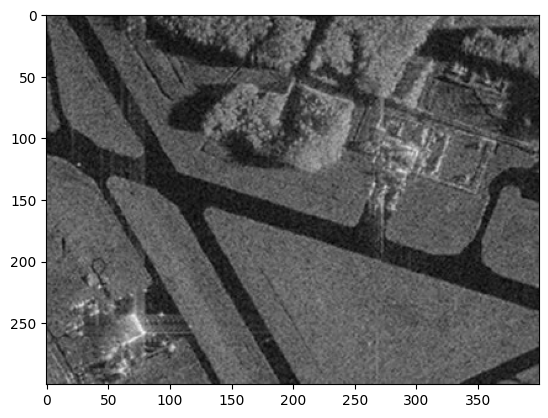

In [3]:
image = cv2.imread('/content/sample_data/sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")

In [4]:
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])
    if abs(av_val - img[point]) <= T:
        return True
    return False

In [5]:
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask*255

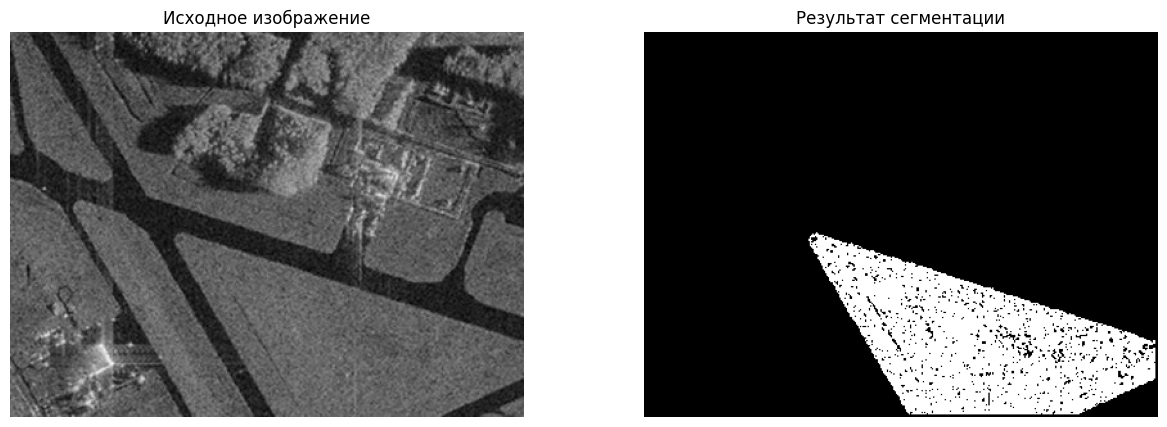

In [6]:
seed_point = (250, 250)
mask_lawn = region_growing(image_gray, seed_point, homo_average, 2, 15)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_lawn, cmap="gray")
plt.title("Результат сегментации")
plt.axis('off')
plt.show()

In [7]:
def homo_std(img, mask, point, T):
    region_pixels = img[mask > 0]
    if len(region_pixels) == 0:
        return True
    std_val = np.std(region_pixels)
    mean_val = np.mean(region_pixels)
    return abs(mean_val - img[point]) <= T and std_val <= 20

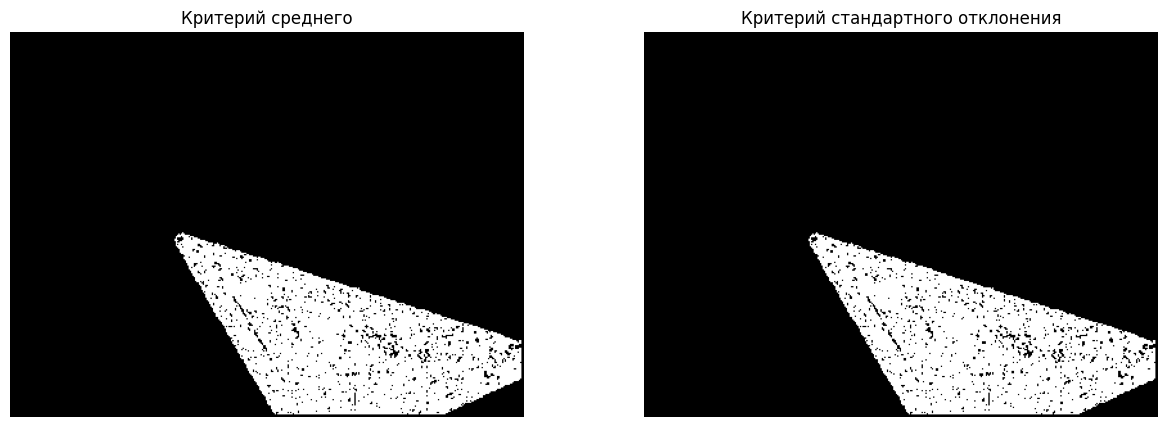

Пикселей (среднее): 19437
Пикселей (std): 19437


In [8]:
mask_std = region_growing(image_gray, seed_point, homo_std, 2, 15)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_lawn, cmap="gray")
plt.title("Критерий среднего")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_std, cmap="gray")
plt.title("Критерий стандартного отклонения")
plt.axis('off')
plt.show()

print(f"Пикселей (среднее): {np.count_nonzero(mask_lawn)}")
print(f"Пикселей (std): {np.count_nonzero(mask_std)}")

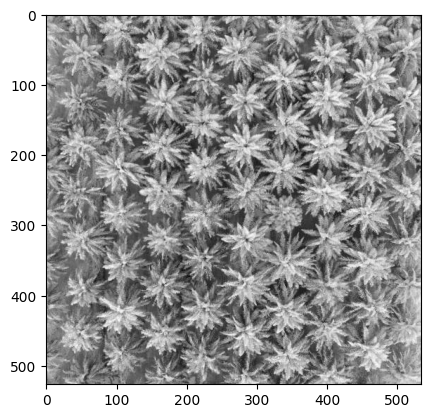

In [9]:
palm_image = cv2.imread('/content/sample_data/palm_1.JPG')
palm_rgb = cv2.cvtColor(palm_image, cv2.COLOR_BGR2RGB)
palm_gray = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)

plt.imshow(palm_gray, cmap="gray")
plt.show()

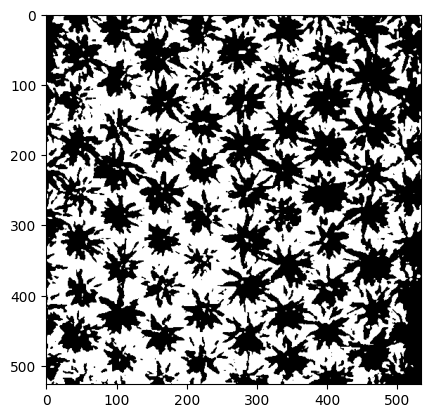

In [10]:
blurred = cv2.GaussianBlur(palm_gray, (5, 5), 0)
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(binary, cmap="gray")
plt.show()

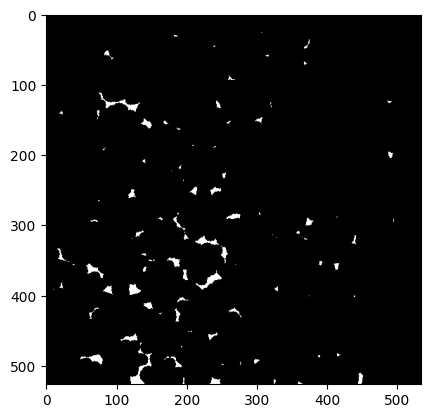

In [11]:
dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = sure_fg.astype(np.uint8)

plt.imshow(sure_fg, cmap="gray")
plt.show()

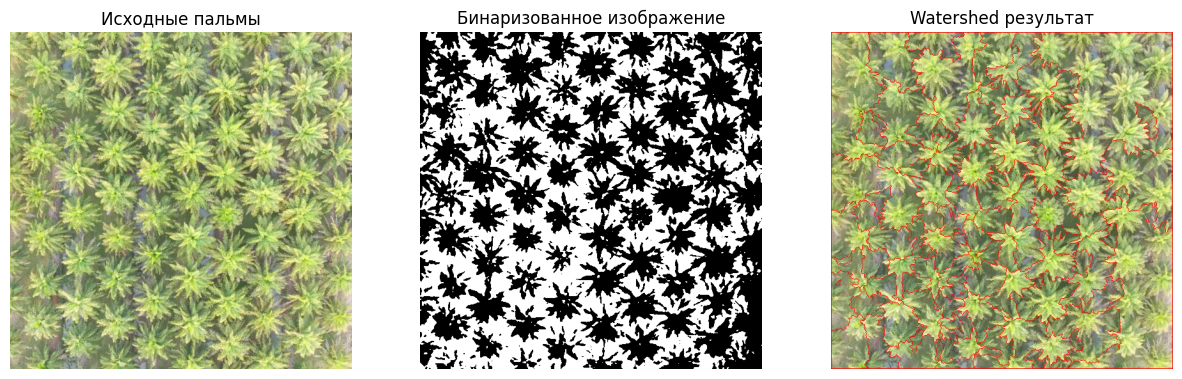

Количество пальмовых деревьев: 106


In [12]:
_, markers = cv2.connectedComponents(sure_fg)
result_image = palm_image.copy()
markers = cv2.watershed(result_image, markers.astype(np.int32))
result_image[markers == -1] = [0, 0, 255]

palm_count = len(np.unique(markers)) - 1

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(palm_rgb)
plt.title("Исходные пальмы")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary, cmap='gray')
plt.title("Бинаризованное изображение")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title("Watershed результат")
plt.axis('off')
plt.show()

print(f"Количество пальмовых деревьев: {palm_count}")